In [1]:
!pip3 install seaborn --user
!pip3 install --index-url  http://pyrrepo.int.cdphp.com/pypi/simple --trusted-host pyrrepo.int.cdphp.com --user pyarrow

You are using pip version 9.0.3, however version 20.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 20.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq


from pathlib import Path
import boto3

pd.set_option("display.max_columns", 150)

### Download Canary data  Locally

In [3]:
%%capture
Path('../data').mkdir(exist_ok = 'True')
try:
    !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/DataSources/PROGRAMS/CANARY/ ../data --recursive;
    s = 'Success to Download Data'
except:
    s = "Failure to Download data"

In [4]:
print(s)

Success to Download Data


# Read Canary data in Pandas Array

In [5]:
data = pq.read_table('../data/PERSON_SUMMARY').to_pandas()

In [6]:
data.head()

PERS_ID       MBR_ID GROUPNUMBER               GROUPNAME       LOB  \
0  2638452  M0006106300       37330  Medicare Advantage 175  Medicare   
1  2706146  M0010332600       36550  Medicare Advantage 125  Medicare   
2  4122088  CD116486701       35938          365 LifePoints        LG   
3  4254340  CD127136501       35938          365 LifePoints        LG   
4  4275621  CD128714401       35938          365 LifePoints       ASO   

                                           FILE_NAME   FILE_DATE  \
0  s3://cdphp-s3-us-e-p-datalake/RAW/NATIVE/WELLT...  2020-09-07   
1  s3://cdphp-s3-us-e-p-datalake/RAW/NATIVE/WELLT...  2020-09-07   
2  s3://cdphp-s3-us-e-p-datalake/RAW/NATIVE/WELLT...  2020-09-07   
3  s3://cdphp-s3-us-e-p-datalake/RAW/NATIVE/WELLT...  2020-09-07   
4  s3://cdphp-s3-us-e-p-datalake/RAW/NATIVE/WELLT...  2020-09-07   

   N_MILESTONES_ACHIEVED REGISTER_DATE LAST_ACTIVITY_DATE  \
0                      1    2020-01-26         2020-01-26   
1                      9    2020-05-27         2020-08-31   
2                     17    2019-11-20         2020-05-29   
3                     17    2019-02-04         2019-07-24   
4                     16    2020-01-24         2020-09-01   

    LAST_COMPLETED_MILESTONE  
0              REGISTER_DATE  
1   9TH_LESSON_COMPLETE_DATE  
2  17TH_LESSON_COMPLETE_DATE  
3  17TH_LESSON_COMPLETE_DATE  
4  16TH_LESSON_COMPLETE_DATE

In [7]:
data.describe()

N_MILESTONES_ACHIEVED
count            1237.000000
mean               12.046079
std                 6.852017
min                 1.000000
25%                 5.000000
50%                16.000000
75%                17.000000
max                25.000000

#### Patients in control group based on 2 criteria
1. REGISTER_DATE is the same with LAST_ACTIVITY_DATE
2. N_MILESTONES_ACHIEVED is less than the median milestones achieved

In [8]:
control = ((data['REGISTER_DATE'] == data['LAST_ACTIVITY_DATE']) |  (data['N_MILESTONES_ACHIEVED'] < data['N_MILESTONES_ACHIEVED'].median()))
treatment_group = ~control

data['TREATED'] = 0
data.loc[treatment_group, 'TREATED'] = 1

In [9]:

s3 = boto3.client('s3')
bucket = 'cdphp-s3-us-e-p-pond'

In [10]:
data.TREATED.sum(), data.shape

(732, (1237, 12))

In [11]:
from pathlib import Path
Path('../temp/').mkdir(exist_ok = 'True')

# Download Pre 2019 data and post 2018

In [12]:
### Download PMPM data in a Parquet File


s3.download_file(bucket, 'rpi/xshou/female_tr', '../temp/pre_female_tr')
s3.download_file(bucket, 'rpi/xshou/female_ts', '../temp/pre_female_ts')
s3.download_file(bucket, 'rpi/xshou/male_tr', '../temp/pre_male_tr')
s3.download_file(bucket, 'rpi/xshou/male_ts', '../temp/pre_male_ts')
s3.download_file(bucket, 'rpi/DataSources/FROM_POND/CA/rpi_mlr_pmpm_new_file_post18.csv', '../temp/pmpm_post18')

In [13]:
df = pd.DataFrame()

for file in Path('../temp/').iterdir():
    if file.is_file():
        if 'pre' in file.name:
            print(file.name)
            df = pd.concat((df, pd.read_pickle(file)), axis = 0)
        
#df_subset = df[df.PERSON_ID.isin(ids)].reset_index(drop = True)
#df_subset.MYR.max()

pre_female_tr
pre_female_ts
pre_male_tr
pre_male_ts


In [14]:
df_post18 = pd.read_csv('../temp/pmpm_post18')


In [15]:
df_post18.drop(columns='MEMBER_ID', inplace = True)
df_post18.replace(['F', 'M'], [0,1], inplace = True)

# Remove extra columns of pre 18 to align with post 18

In [16]:
extra_pre = np.setdiff1d(df.columns, df_post18.columns)
df.drop(columns = extra_pre, inplace = True)

In [17]:
print(df_post18.shape, df.shape)
df = pd.concat((df, df_post18), axis = 0)
del df_post18
df.shape

(11434161, 89) (24783659, 89)


(36217820, 89)

In [18]:
df.MYR.max()

202006

## Filter for months that are included in the PMPM data

In [19]:
import datetime as dt
filter_dates =  (data.REGISTER_DATE <= dt.date(2020, 6, 30))

In [20]:
data[~filter_dates].shape

(48, 12)

In [21]:
data_filt = data[filter_dates].copy().reset_index(drop = True)
ids = data_filt.PERS_ID.unique().astype(int)
data_filt.shape, data[~filter_dates].shape, data.shape


((1189, 12), (48, 12), (1237, 12))

# Filter For ids common in PMPM and Canary

In [22]:

df_filt = df[df.PERSON_ID.isin(ids)].reset_index(drop = True)
df_filt.to_pickle('../temp/df_filt.p')
df_filt.PERSON_ID.unique().shape, df_filt.MYR.max()

((1189,), 202006)

In [23]:
df_filt.shape

(84883, 89)

In [24]:
cost_columns = [col for col in df_filt.columns if 'allow' in col]
df_filt['cost_month'] = df_filt[cost_columns].sum(axis = 1)


df_filt[['PERSON_ID', 'MYR', 'cost_month']].describe()

PERSON_ID            MYR     cost_month
count  8.488300e+04   84883.000000   84883.000000
mean   3.298327e+06  201720.061567    1146.291927
std    5.637863e+05     179.764960    5623.125250
min    2.602482e+06  201401.000000       0.000000
25%    2.853560e+06  201602.000000       0.000000
50%    3.028592e+06  201801.000000     188.760000
75%    3.923202e+06  201812.000000     727.690000
max    5.036817e+06  202006.000000  789031.180000

### Setting all the covariates whatever is related to diagnostic codes plus age, gender, DAYS_IP, DAYS_SNF

In [25]:
covariates = [col for col in df_filt.columns if 'cc' in col]
covariates.extend(['DAYS_IP', 'DAYS_SNF','age_at_midmonth', 'MBR_GNDR' ])

## Add covariate and cost columns in canary data

In [26]:
for col in covariates:
    data_filt[col] = 0
data_filt['init_cost'] = 0
data_filt['final_cost'] = 0

In [27]:
data_filt.shape

(1189, 87)

In [28]:
data_filt2 = data_filt.copy()
missing  = []
months = 8
actual_months = []
td = dt.timedelta(30*6)
for i in range(data_filt.shape[0]):
    #get line from canary
    ser = data_filt.iloc[i]
    
    #get id
    idi = ser.PERS_ID
    
    #get register date
    reg_date = ser.REGISTER_DATE
    reg_avg_date = reg_date-td
    reg_avg_date_after = reg_date+td

    
    #transform date
    myr_en = reg_date.year*100 + reg_date.month
    myr_st = reg_avg_date.year*100 + reg_avg_date.month
    myr_en_after = reg_avg_date_after.year*100 + reg_avg_date_after.month

    int_id = int(idi)
    
    #match id with pmpm data
    data_cov =df_filt[df_filt.PERSON_ID == int_id]
    
    #match id and register date with PMPM data
    init_cost_m = data_cov[(data_cov.MYR < myr_en) & (data_cov.MYR > myr_st)]['cost_month']
    last_cost_m = data_cov[(data_cov.MYR >= myr_en) & (data_cov.MYR < myr_en_after)]['cost_month']
    
    init_cost = init_cost_m.mean()
    last_cost = last_cost_m.mean()

    actual_months.append( [init_cost_m.shape[0], last_cost_m.shape[0]] )
    
    data_first_date = data_cov[(data_cov.MYR == myr_en)]
    data_last_date = data_cov[(data_cov.MYR == data_cov.MYR.max())]
    
    
    #assign covariates 
    try:
        data_filt2.loc[i, covariates] = data_first_date[covariates].values[0,:]
        data_filt2.loc[i, 'init_cost'] = init_cost
        data_filt2.loc[i, 'final_cost'] = last_cost
    except:
        missing.append(i)

    

In [29]:
data_filt2.shape, missing

((1189, 87), [853])

In [30]:
data_filt2.drop(index = missing, inplace = True)
data_filt2 = data_filt2.reset_index(drop = True)

In [31]:
data_filt2.to_pickle('../temp/final_causal.p')

In [32]:
data_filt2['outcome'] = data_filt2['final_cost'] - data_filt2['init_cost']
data_filt2['Y'] = 0
data_filt2.loc[data_filt2['outcome'] <= 0, 'Y'] = 1

In [33]:
#filter null
data_filt2 = data_filt2[~data_filt2.init_cost.isnull()]

In [34]:
data_filt2.shape

(1183, 89)

## From here we need to run with the same random seed 

In [35]:
np.random.seed(seed=0)

## Calculate Average Treatment Effect (Outcome) with the Naive Separation in Control and Treatment

In [36]:
treated = data_filt2.TREATED == 1
print("ATT:{:.10f}".format( data_filt2[treated].Y.mean()- data_filt2[~treated].Y.mean()))

ATT:-0.1093271431


## Propensity Score Matching

In [37]:
covariates_v2 = covariates.copy()
covariates_v2.extend(['N_MILESTONES_ACHIEVED'])

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X, Y = data_filt2[covariates_v2], data_filt2.TREATED

ss = StandardScaler()
pca = PCA(n_components=5)
Xtr   = pca.fit_transform(ss.fit_transform(X.values))

In [39]:
data_filt2.shape, Xtr.shape

((1183, 89), (1183, 5))

In [40]:
data_treat = data_filt2[treated].reset_index(drop = True)
data_contr= data_filt2[~treated].reset_index(drop = True)

In [41]:
data_treat.shape, data_contr.shape

((731, 89), (452, 89))

In [42]:
lg = LogisticRegression(fit_intercept=True, penalty='l2')
lg = lg.fit(Xtr, Y.values)

/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [43]:
probas_t = lg.predict_proba(Xtr[treated])[:,1]
probas_c = lg.predict_proba(Xtr[~treated])[:,1]

In [44]:
probas_t.shape, probas_c.shape

((731,), (452,))

In [45]:
print("min-max probabilities of treatment and control after lg fit")
probas_c.max(), probas_c.min(), probas_t.max(), probas_t.min()

min-max probabilities of treatment and control after lg fit


(0.9006521393602231, 4.332975389925097e-05, 1.0, 0.05978078732714492)

### Match Control and Treatment Units

In [46]:
from sklearn.metrics.pairwise import euclidean_distances

dist = np.sqrt(euclidean_distances(X=probas_t[:,np.newaxis], Y=probas_c[:,np.newaxis]))
dist_min = dist.min(axis = 1)
dist_med = np.median(dist_min)

## Caliper Matching - Specify maximum distance for matching (Reduces the Bias (better matching), increses the estimator variance less samples matched)

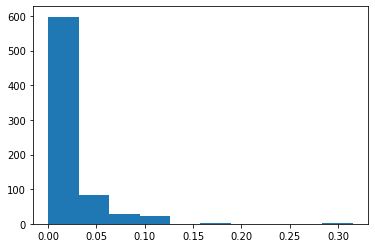

In [47]:
plt.hist(dist_min)
plt.show()

In [48]:
control_matches = np.argmin(dist, axis = 1)

In [49]:
data_c = data_filt2[~treated].Y.reset_index(drop = True)
data_t = data_filt2[treated].Y.reset_index(drop = True)
data_cc = data_c[control_matches]

In [50]:
data_treat.shape, data_t.shape, data_cc.shape, data_c.shape

((731, 89), (731,), (731,), (452,))

### Caclculate and Save the Treated and Matched Control IDs

In [51]:
data_cont_f = data_contr.iloc[control_matches]

In [52]:
matched_controls_ID = data_cont_f.PERS_ID.unique()
treated_ids         = data_treat.PERS_ID.unique()
ids_to_match = {'treated': treated_ids, 'control':matched_controls_ID}

In [53]:
import pickle as pkl
pkl.dump(ids_to_match, open('../temp/matching_ids.p', 'wb') )

In [54]:
dist_med

0.014794132911855565

# P(T = 1 | X)  --> Y(0), Y(1), T are independent given b(x)

## Calculate Average Treatment Effect (Outcome) with the a simple Propensity Matching Technique
## No Caliper

In [55]:
print("ATT:{:.6f}".format( data_t.mean() - data_cc.mean()))

ATT:-0.164159


### Calculate Treatment Effect with Caliper

In [56]:
#filter by caliper interval
caliper = dist_min <= dist_med

#get all the control indexes after caliper matching
control_matches_caliper = control_matches[caliper]

In [57]:
data_cc_caliper = data_c[control_matches_caliper]
data_t_caliper  = data_t[caliper]

In [58]:
data_cc_caliper.shape, data_t_caliper.shape

((366,), (366,))

## With Caliper

In [59]:
print("ATT Caliper:{:.6f}".format( data_t_caliper.mean() - data_cc_caliper.mean()))

ATT Caliper:-0.177596


In [60]:
columns_for_pairplot = ['age_at_midmonth', 'MBR_GNDR', 'init_cost', 'final_cost', 'outcome', 'TREATED', 'Y']
varsa  = ['age_at_midmonth', 'MBR_GNDR', 'init_cost', 'final_cost', 'outcome']
data_exam = data_filt2[columns_for_pairplot].copy()


## Pairplots By Treatment and by Outcome

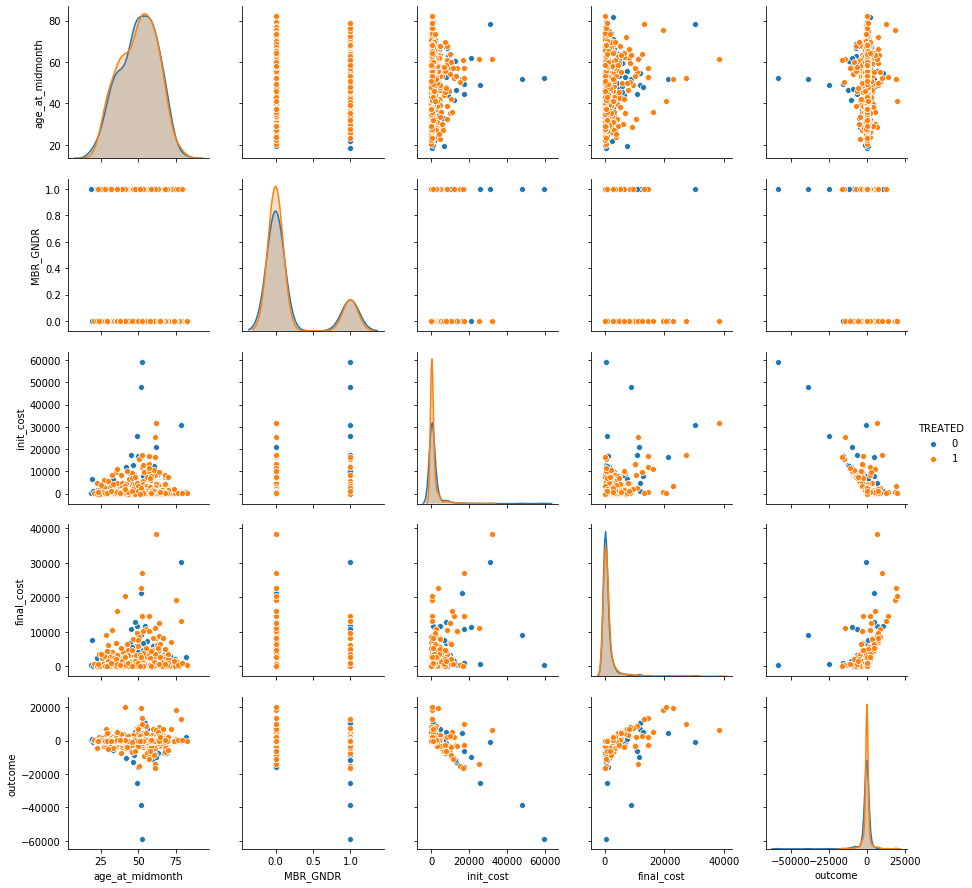

In [61]:
sns.pairplot(data_exam, hue = 'TREATED',vars = varsa, kind = 'scatter', diag_kind = 'auto')
plt.show()

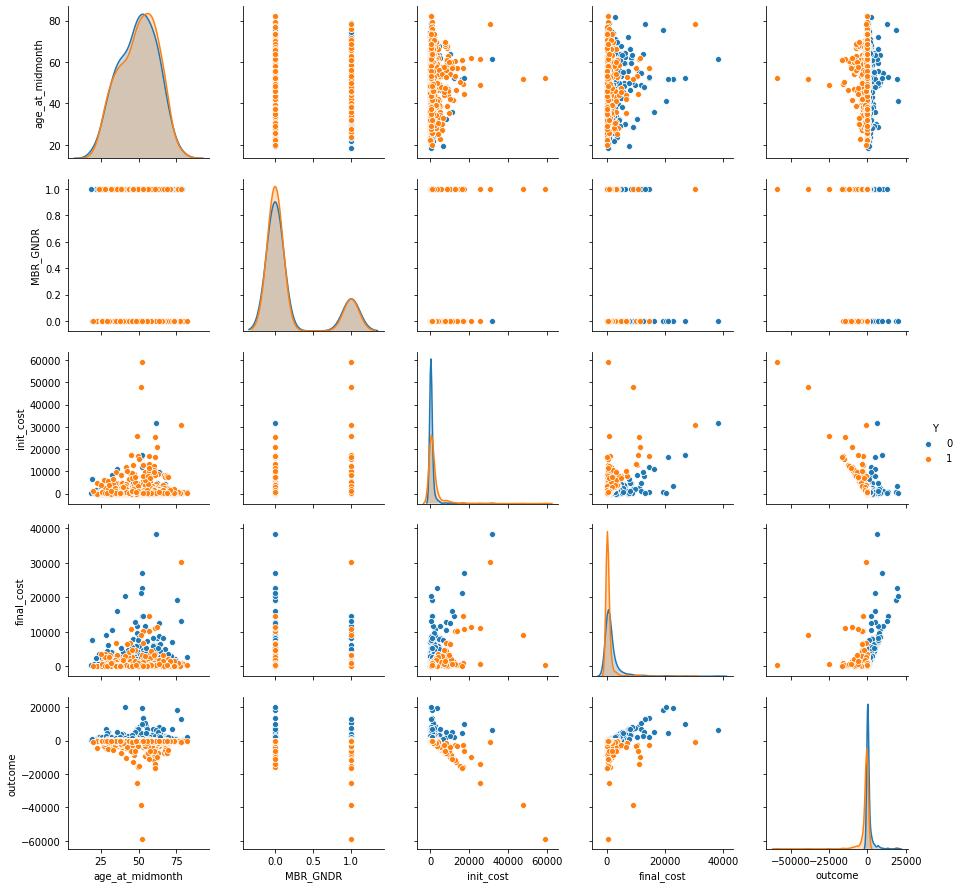

In [62]:
sns.pairplot(data_exam, hue = 'Y',vars = varsa, kind = 'scatter', diag_kind = 'auto')
plt.show()